In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 35914 
    Total predicted counts          : 35758.48
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 14.9 s, sys: 83.5 ms, total: 14.9 s
Wall time: 14.9 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 36169 
    Total predicted counts          : 35806.08
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 35665 
    Total predicted counts          : 35869.68
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 36175 
    Total predicted counts          : 35714.88
    Total off counts                : 101218.00

    Total background counts         : 20243.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 35557 
    Total predicted counts          : 35669.08
    Total off counts                : 100989.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 35446 
    Total predicted counts          : 35668.68
    Total off counts                : 100987.00

    Total background counts         : 20197.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 35354 
    Total predicted counts          : 35748.48
    Total off counts                : 101386.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_100 

    Total counts                    : 35956 
    Total predicted counts          : 35801.48
    Total off counts                : 101651.00

    Total background counts         : 20330.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_101 

    Total counts                    : 35761 
    Total predicted counts          : 35822.68
    Total off counts                : 101757.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_137 

    Total counts                    : 36241 
    Total predicted counts          : 35759.28
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_138 

    Total counts                    : 35431 
    Total predicted counts          : 35752.28
    Total off counts                : 101405.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 35559 
    Total predicted counts          : 35835.68
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 35758 
    Total predicted counts          : 35736.68
    Total off counts                : 101327.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 35900 
    Total predicted counts          : 35661.08
    Total off counts                : 100949.00

    Total background counts         : 20189.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_209 

    Total counts                    : 35969 
    Total predicted counts          : 35699.48
    Total off counts                : 101141.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 35811 
    Total predicted counts          : 35668.48
    Total off counts                : 100986.00

    Total background counts         : 20197.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 35548 
    Total predicted counts          : 35860.68
    Total off counts                : 101947.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_280 

    Total counts                    : 35921 
    Total predicted counts          : 35838.48
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_281 

    Total counts                    : 35243 
    Total predicted counts          : 35755.28
    Total off counts                : 101420.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_317 

    Total counts                    : 35518 
    Total predicted counts          : 35787.48
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_318 

    Total counts                    : 35835 
    Total predicted counts          : 35829.68
    Total off counts                : 101792.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_352 

    Total counts                    : 35939 
    Total predicted counts          : 35899.68
    Total off counts                : 102142.00

    Total background counts         : 20428.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_353 

    Total counts                    : 35753 
    Total predicted counts          : 35782.08
    Total off counts                : 101554.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_387 

    Total counts                    : 35718 
    Total predicted counts          : 35835.08
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_388 

    Total counts                    : 35862 
    Total predicted counts          : 35841.08
    Total off counts                : 101849.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_424 

    Total counts                    : 35536 
    Total predicted counts          : 35778.08
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_425 

    Total counts                    : 35863 
    Total predicted counts          : 35791.28
    Total off counts                : 101600.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_459 

    Total counts                    : 35801 
    Total predicted counts          : 35711.08
    Total off counts                : 101199.00

    Total background counts         : 20239.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 35755 
    Total predicted counts          : 35779.68
    Total off counts                : 101542.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 35730 
    Total predicted counts          : 35851.08
    Total off counts                : 101899.00

    Total background counts         : 20379.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 36023 
    Total predicted counts          : 35702.28
    Total off counts                : 101155.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_532 

    Total counts                    : 35556 
    Total predicted counts          : 35809.68
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_533 

    Total counts                    : 35713 
    Total predicted counts          : 35757.48
    Total off counts                : 101431.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 35793 
    Total predicted counts          : 35768.68
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 36046 
    Total predicted counts          : 35775.88
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 36042 
    Total predicted counts          : 35794.68
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 35701 
    Total predicted counts          : 35731.88
    Total off counts                : 101303.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_641 

    Total counts                    : 35597 
    Total predicted counts          : 35857.48
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_642 

    Total counts                    : 35349 
    Total predicted counts          : 35798.68
    Total off counts                : 101637.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_677 

    Total counts                    : 35775 
    Total predicted counts          : 35831.28
    Total off counts                : 101800.00

    Total background counts         : 20360.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_678 

    Total counts                    : 35957 
    Total predicted counts          : 35751.28
    Total off counts                : 101400.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_712 

    Total counts                    : 35938 
    Total predicted counts          : 35774.08
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_713 

    Total counts                    : 35590 
    Total predicted counts          : 35781.68
    Total off counts                : 101552.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_748 

    Total counts                    : 35808 
    Total predicted counts          : 35797.28
    Total off counts                : 101630.00

    Total background counts         : 20326.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 35764 
    Total predicted counts          : 35756.28
    Total off counts                : 101425.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_785 

    Total counts                    : 35453 
    Total predicted counts          : 35743.08
    Total off counts                : 101359.00

    Total background counts         : 20271.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_786 

    Total counts                    : 36116 
    Total predicted counts          : 35734.88
    Total off counts                : 101318.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_821 

    Total counts                    : 35558 
    Total predicted counts          : 35656.88
    Total off counts                : 100928.00

    Total background counts         : 20185.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_822 

    Total counts                    : 35722 
    Total predicted counts          : 35797.08
    Total off counts                : 101629.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_857 

    Total counts                    : 35447 
    Total predicted counts          : 35801.08
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_858 

    Total counts                    : 35708 
    Total predicted counts          : 35845.48
    Total off counts                : 101871.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_893 

    Total counts                    : 35661 
    Total predicted counts          : 35746.68
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_894 

    Total counts                    : 35662 
    Total predicted counts          : 35799.88
    Total off counts                : 101643.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_930 

    Total counts                    : 35926 
    Total predicted counts          : 35754.88
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_931 

    Total counts                    : 35621 
    Total predicted counts          : 35802.28
    Total off counts                : 101655.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_965 

    Total counts                    : 35936 
    Total predicted counts          : 35855.28
    Total off counts                : 101920.00

    Total background counts         : 20384.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_966 

    Total counts                    : 36008 
    Total predicted counts          : 35707.48
    Total off counts                : 101181.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1001 

    Total counts                    : 35644 
    Total predicted counts          : 35696.68
    Total off counts                : 101127.00

    Total background counts         : 20225.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1002 

    Total counts                    : 35326 
    Total predicted counts          : 35870.68
    Total off counts                : 101997.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1036 

    Total counts                    : 36080 
    Total predicted counts          : 35768.68
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1037 

    Total counts                    : 35882 
    Total predicted counts          : 35926.68
    Total off counts                : 102277.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1073 

    Total counts                    : 35637 
    Total predicted counts          : 35844.48
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1074 

    Total counts                    : 35974 
    Total predicted counts          : 35773.48
    Total off counts                : 101511.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1109 

    Total counts                    : 35905 
    Total predicted counts          : 35795.28
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1110 

    Total counts                    : 35725 
    Total predicted counts          : 35905.68
    Total off counts                : 102172.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1145 

    Total counts                    : 36221 
    Total predicted counts          : 35829.48
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1146 

    Total counts                    : 36149 
    Total predicted counts          : 35835.28
    Total off counts                : 101820.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1181 

    Total counts                    : 35717 
    Total predicted counts          : 35698.48
    Total off counts                : 101136.00

    Total background counts         : 20227.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1182 

    Total counts                    : 35982 
    Total predicted counts          : 35799.08
    Total off counts                : 101639.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1216 

    Total counts                    : 35808 
    Total predicted counts          : 35870.08
    Total off counts                : 101994.00

    Total background counts         : 20398.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1217 

    Total counts                    : 35763 
    Total predicted counts          : 35812.28
    Total off counts                : 101705.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1252 

    Total counts                    : 35339 
    Total predicted counts          : 35794.68
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1253 

    Total counts                    : 36019 
    Total predicted counts          : 35671.28
    Total off counts                : 101000.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1290 

    Total counts                    : 35556 
    Total predicted counts          : 35818.28
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1291 

    Total counts                    : 35736 
    Total predicted counts          : 35686.88
    Total off counts                : 101078.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1327 

    Total counts                    : 35826 
    Total predicted counts          : 35792.48
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1328 

    Total counts                    : 35836 
    Total predicted counts          : 35863.08
    Total off counts                : 101959.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1361 

    Total counts                    : 35828 
    Total predicted counts          : 35774.08
    Total off counts                : 101514.00

    Total background counts         : 20302.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1362 

    Total counts                    : 35600 
    Total predicted counts          : 35797.68
    Total off counts                : 101632.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1397 

    Total counts                    : 35730 
    Total predicted counts          : 35768.28
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1398 

    Total counts                    : 35939 
    Total predicted counts          : 35781.08
    Total off counts                : 101549.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1433 

    Total counts                    : 36180 
    Total predicted counts          : 35752.48
    Total off counts                : 101406.00

    Total background counts         : 20281.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1434 

    Total counts                    : 35574 
    Total predicted counts          : 35797.48
    Total off counts                : 101631.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1468 

    Total counts                    : 35957 
    Total predicted counts          : 35770.88
    Total off counts                : 101498.00

    Total background counts         : 20299.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1469 

    Total counts                    : 35832 
    Total predicted counts          : 35762.48
    Total off counts                : 101456.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1502 

    Total counts                    : 35636 
    Total predicted counts          : 35830.08
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1503 

    Total counts                    : 35641 
    Total predicted counts          : 35846.48
    Total off counts                : 101876.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1537 

    Total counts                    : 35728 
    Total predicted counts          : 35664.08
    Total off counts                : 100964.00

    Total background counts         : 20192.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1538 

    Total counts                    : 35925 
    Total predicted counts          : 35743.28
    Total off counts                : 101360.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1572 

    Total counts                    : 35851 
    Total predicted counts          : 35766.88
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1573 

    Total counts                    : 35606 
    Total predicted counts          : 35784.88
    Total off counts                : 101568.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1609 

    Total counts                    : 35721 
    Total predicted counts          : 35789.48
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1610 

    Total counts                    : 36072 
    Total predicted counts          : 35743.48
    Total off counts                : 101361.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1645 

    Total counts                    : 35802 
    Total predicted counts          : 35797.48
    Total off counts                : 101631.00

    Total background counts         : 20326.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1646 

    Total counts                    : 36079 
    Total predicted counts          : 35715.68
    Total off counts                : 101222.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1681 

    Total counts                    : 35493 
    Total predicted counts          : 35763.28
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1682 

    Total counts                    : 35325 
    Total predicted counts          : 35815.48
    Total off counts                : 101721.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1717 

    Total counts                    : 35599 
    Total predicted counts          : 35852.28
    Total off counts                : 101905.00

    Total background counts         : 20381.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1718 

    Total counts                    : 35608 
    Total predicted counts          : 35776.68
    Total off counts                : 101527.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1754 

    Total counts                    : 35489 
    Total predicted counts          : 35790.68
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1755 

    Total counts                    : 35647 
    Total predicted counts          : 35873.88
    Total off counts                : 102013.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1790 

    Total counts                    : 35853 
    Total predicted counts          : 35780.28
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1791 

    Total counts                    : 35772 
    Total predicted counts          : 35788.28
    Total off counts                : 101585.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1826 

    Total counts                    : 35800 
    Total predicted counts          : 35746.68
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1827 

    Total counts                    : 35651 
    Total predicted counts          : 35816.48
    Total off counts                : 101726.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1862 

    Total counts                    : 35612 
    Total predicted counts          : 35729.68
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1863 

    Total counts                    : 35680 
    Total predicted counts          : 35720.08
    Total off counts                : 101244.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1899 

    Total counts                    : 35591 
    Total predicted counts          : 35826.08
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1900 

    Total counts                    : 35743 
    Total predicted counts          : 35858.08
    Total off counts                : 101934.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 35874 
    Total predicted counts          : 35924.48
    Total off counts                : 102266.00

    Total background counts         : 20453.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 35947 
    Total predicted counts          : 35798.68
    Total off counts                : 101637.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1972 

    Total counts                    : 35512 
    Total predicted counts          : 35881.48
    Total off counts                : 102051.00

    Total background counts         : 20410.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1973 

    Total counts                    : 35961 
    Total predicted counts          : 35944.48
    Total off counts                : 102366.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2008 

    Total counts                    : 35738 
    Total predicted counts          : 35761.08
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2009 

    Total counts                    : 35612 
    Total predicted counts          : 35788.48
    Total off counts                : 101586.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2042 

    Total counts                    : 36189 
    Total predicted counts          : 35830.28
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2043 

    Total counts                    : 35779 
    Total predicted counts          : 35768.08
    Total off counts                : 101484.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2077 

    Total counts                    : 36075 
    Total predicted counts          : 35742.48
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2078 

    Total counts                    : 35716 
    Total predicted counts          : 35789.48
    Total off counts                : 101591.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2113 

    Total counts                    : 35766 
    Total predicted counts          : 35900.28
    Total off counts                : 102145.00

    Total background counts         : 20429.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2114 

    Total counts                    : 35977 
    Total predicted counts          : 35786.48
    Total off counts                : 101576.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2149 

    Total counts                    : 35293 
    Total predicted counts          : 35836.68
    Total off counts                : 101827.00

    Total background counts         : 20365.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2150 

    Total counts                    : 35617 
    Total predicted counts          : 35788.28
    Total off counts                : 101585.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2185 

    Total counts                    : 35750 
    Total predicted counts          : 35908.48
    Total off counts                : 102186.00

    Total background counts         : 20437.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2186 

    Total counts                    : 35780 
    Total predicted counts          : 35817.68
    Total off counts                : 101732.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2219 

    Total counts                    : 35701 
    Total predicted counts          : 35641.28
    Total off counts                : 100850.00

    Total background counts         : 20170.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2220 

    Total counts                    : 35738 
    Total predicted counts          : 35836.88
    Total off counts                : 101828.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2256 

    Total counts                    : 35705 
    Total predicted counts          : 35658.48
    Total off counts                : 100936.00

    Total background counts         : 20187.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2257 

    Total counts                    : 35842 
    Total predicted counts          : 35755.68
    Total off counts                : 101422.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2292 

    Total counts                    : 35599 
    Total predicted counts          : 35771.68
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2293 

    Total counts                    : 35877 
    Total predicted counts          : 35843.48
    Total off counts                : 101861.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2327 

    Total counts                    : 35864 
    Total predicted counts          : 35778.08
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2328 

    Total counts                    : 35747 
    Total predicted counts          : 35805.48
    Total off counts                : 101671.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2362 

    Total counts                    : 35958 
    Total predicted counts          : 35695.88
    Total off counts                : 101123.00

    Total background counts         : 20224.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2363 

    Total counts                    : 35650 
    Total predicted counts          : 35795.68
    Total off counts                : 101622.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2398 

    Total counts                    : 35794 
    Total predicted counts          : 35671.28
    Total off counts                : 101000.00

    Total background counts         : 20200.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2399 

    Total counts                    : 35871 
    Total predicted counts          : 35759.68
    Total off counts                : 101442.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2433 

    Total counts                    : 35856 
    Total predicted counts          : 35755.88
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2434 

    Total counts                    : 35781 
    Total predicted counts          : 35876.48
    Total off counts                : 102026.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2469 

    Total counts                    : 35652 
    Total predicted counts          : 35783.48
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2470 

    Total counts                    : 35836 
    Total predicted counts          : 35801.68
    Total off counts                : 101652.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2504 

    Total counts                    : 35649 
    Total predicted counts          : 35758.28
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2505 

    Total counts                    : 35568 
    Total predicted counts          : 35775.28
    Total off counts                : 101520.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2540 

    Total counts                    : 35870 
    Total predicted counts          : 35884.48
    Total off counts                : 102066.00

    Total background counts         : 20413.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2541 

    Total counts                    : 35667 
    Total predicted counts          : 35776.28
    Total off counts                : 101525.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2576 

    Total counts                    : 35463 
    Total predicted counts          : 35804.68
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2577 

    Total counts                    : 35400 
    Total predicted counts          : 35838.08
    Total off counts                : 101834.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2611 

    Total counts                    : 36243 
    Total predicted counts          : 35848.08
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2612 

    Total counts                    : 36219 
    Total predicted counts          : 35707.08
    Total off counts                : 101179.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2646 

    Total counts                    : 35898 
    Total predicted counts          : 35691.28
    Total off counts                : 101100.00

    Total background counts         : 20220.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2647 

    Total counts                    : 35834 
    Total predicted counts          : 35753.08
    Total off counts                : 101409.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2682 

    Total counts                    : 35971 
    Total predicted counts          : 35872.08
    Total off counts                : 102004.00

    Total background counts         : 20400.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2683 

    Total counts                    : 35691 
    Total predicted counts          : 35793.28
    Total off counts                : 101610.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2693 

    Total counts                    : 35943 
    Total predicted counts          : 35740.08
    Total off counts                : 101344.00

    Total background counts         : 20268.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2694 

    Total counts                    : 35636 
    Total predicted counts          : 35821.68
    Total off counts                : 101752.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2719 

    Total counts                    : 35749 
    Total predicted counts          : 35917.68
    Total off counts                : 102232.00

    Total background counts         : 20446.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2720 

    Total counts                    : 36518 
    Total predicted counts          : 35688.28
    Total off counts                : 101085.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2753 

    Total counts                    : 35886 
    Total predicted counts          : 35831.48
    Total off counts                : 101801.00

    Total background counts         : 20360.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2754 

    Total counts                    : 35922 
    Total predicted counts          : 35759.08
    Total off counts                : 101439.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2765 

    Total counts                    : 35717 
    Total predicted counts          : 35825.08
    Total off counts                : 101769.00

    Total background counts         : 20353.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2766 

    Total counts                    : 35929 
    Total predicted counts          : 35748.68
    Total off counts                : 101387.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2789 

    Total counts                    : 35671 
    Total predicted counts          : 35762.48
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2790 

    Total counts                    : 35795 
    Total predicted counts          : 35905.48
    Total off counts                : 102171.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2800 

    Total counts                    : 35780 
    Total predicted counts          : 35800.68
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2801 

    Total counts                    : 35944 
    Total predicted counts          : 35844.08
    Total off counts                : 101864.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2826 

    Total counts                    : 35570 
    Total predicted counts          : 35830.68
    Total off counts                : 101797.00

    Total background counts         : 20359.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2827 

    Total counts                    : 35978 
    Total predicted counts          : 35737.48
    Total off counts                : 101331.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2862 

    Total counts                    : 36068 
    Total predicted counts          : 35826.48
    Total off counts                : 101776.00

    Total background counts         : 20355.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2863 

    Total counts                    : 35870 
    Total predicted counts          : 35782.08
    Total off counts                : 101554.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2899 

    Total counts                    : 35548 
    Total predicted counts          : 35746.88
    Total off counts                : 101378.00

    Total background counts         : 20275.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2900 

    Total counts                    : 36175 
    Total predicted counts          : 35813.68
    Total off counts                : 101712.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2935 

    Total counts                    : 35724 
    Total predicted counts          : 35816.88
    Total off counts                : 101728.00

    Total background counts         : 20345.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2936 

    Total counts                    : 35682 
    Total predicted counts          : 35794.88
    Total off counts                : 101618.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2971 

    Total counts                    : 35695 
    Total predicted counts          : 35761.28
    Total off counts                : 101450.00

    Total background counts         : 20290.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2972 

    Total counts                    : 35712 
    Total predicted counts          : 35703.08
    Total off counts                : 101159.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3008 

    Total counts                    : 35970 
    Total predicted counts          : 35771.68
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3009 

    Total counts                    : 35803 
    Total predicted counts          : 35753.68
    Total off counts                : 101412.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3044 

    Total counts                    : 36138 
    Total predicted counts          : 35804.88
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3045 

    Total counts                    : 36102 
    Total predicted counts          : 35906.28
    Total off counts                : 102175.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3078 

    Total counts                    : 35479 
    Total predicted counts          : 35837.68
    Total off counts                : 101832.00

    Total background counts         : 20366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3079 

    Total counts                    : 35875 
    Total predicted counts          : 35809.88
    Total off counts                : 101693.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3113 

    Total counts                    : 35859 
    Total predicted counts          : 35818.48
    Total off counts                : 101736.00

    Total background counts         : 20347.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3114 

    Total counts                    : 35895 
    Total predicted counts          : 35799.48
    Total off counts                : 101641.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3146 

    Total counts                    : 35627 
    Total predicted counts          : 35699.68
    Total off counts                : 101142.00

    Total background counts         : 20228.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3147 

    Total counts                    : 36009 
    Total predicted counts          : 35813.48
    Total off counts                : 101711.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3181 

    Total counts                    : 35506 
    Total predicted counts          : 35724.68
    Total off counts                : 101267.00

    Total background counts         : 20253.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3182 

    Total counts                    : 35758 
    Total predicted counts          : 35781.48
    Total off counts                : 101551.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3217 

    Total counts                    : 35829 
    Total predicted counts          : 35795.08
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3218 

    Total counts                    : 35843 
    Total predicted counts          : 35755.88
    Total off counts                : 101423.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3253 

    Total counts                    : 35654 
    Total predicted counts          : 35783.68
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3254 

    Total counts                    : 35952 
    Total predicted counts          : 35704.48
    Total off counts                : 101166.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3290 

    Total counts                    : 36160 
    Total predicted counts          : 35754.68
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3291 

    Total counts                    : 35983 
    Total predicted counts          : 35726.28
    Total off counts                : 101275.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3327 

    Total counts                    : 35700 
    Total predicted counts          : 35922.68
    Total off counts                : 102257.00

    Total background counts         : 20451.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3328 

    Total counts                    : 35291 
    Total predicted counts          : 35819.28
    Total off counts                : 101740.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3363 

    Total counts                    : 35841 
    Total predicted counts          : 35737.68
    Total off counts                : 101332.00

    Total background counts         : 20266.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3364 

    Total counts                    : 35950 
    Total predicted counts          : 35696.28
    Total off counts                : 101125.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3398 

    Total counts                    : 36137 
    Total predicted counts          : 35807.08
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3399 

    Total counts                    : 35669 
    Total predicted counts          : 35754.28
    Total off counts                : 101415.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3434 

    Total counts                    : 36133 
    Total predicted counts          : 35795.48
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3435 

    Total counts                    : 35911 
    Total predicted counts          : 35805.48
    Total off counts                : 101671.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3470 

    Total counts                    : 35720 
    Total predicted counts          : 35814.08
    Total off counts                : 101714.00

    Total background counts         : 20342.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3471 

    Total counts                    : 36130 
    Total predicted counts          : 35702.28
    Total off counts                : 101155.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3506 

    Total counts                    : 35622 
    Total predicted counts          : 35861.68
    Total off counts                : 101952.00

    Total background counts         : 20390.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3507 

    Total counts                    : 35980 
    Total predicted counts          : 35921.68
    Total off counts                : 102252.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3541 

    Total counts                    : 35395 
    Total predicted counts          : 35819.68
    Total off counts                : 101742.00

    Total background counts         : 20348.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3542 

    Total counts                    : 35988 
    Total predicted counts          : 35802.68
    Total off counts                : 101657.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3577 

    Total counts                    : 35872 
    Total predicted counts          : 35663.28
    Total off counts                : 100960.00

    Total background counts         : 20192.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3578 

    Total counts                    : 35599 
    Total predicted counts          : 35674.28
    Total off counts                : 101015.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3612 

    Total counts                    : 35866 
    Total predicted counts          : 35820.28
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3613 

    Total counts                    : 35644 
    Total predicted counts          : 35775.08
    Total off counts                : 101519.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3647 

    Total counts                    : 35669 
    Total predicted counts          : 35841.48
    Total off counts                : 101851.00

    Total background counts         : 20370.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3648 

    Total counts                    : 36073 
    Total predicted counts          : 35801.08
    Total off counts                : 101649.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3684 

    Total counts                    : 35733 
    Total predicted counts          : 35902.28
    Total off counts                : 102155.00

    Total background counts         : 20431.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3685 

    Total counts                    : 35712 
    Total predicted counts          : 35798.28
    Total off counts                : 101635.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3721 

    Total counts                    : 35716 
    Total predicted counts          : 35856.88
    Total off counts                : 101928.00

    Total background counts         : 20385.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3722 

    Total counts                    : 36060 
    Total predicted counts          : 35749.08
    Total off counts                : 101389.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3758 

    Total counts                    : 35909 
    Total predicted counts          : 35757.88
    Total off counts                : 101433.00

    Total background counts         : 20286.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3759 

    Total counts                    : 35891 
    Total predicted counts          : 35871.88
    Total off counts                : 102003.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3794 

    Total counts                    : 35801 
    Total predicted counts          : 35729.68
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3795 

    Total counts                    : 35624 
    Total predicted counts          : 35710.68
    Total off counts                : 101197.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3831 

    Total counts                    : 35821 
    Total predicted counts          : 35791.48
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3832 

    Total counts                    : 35646 
    Total predicted counts          : 35821.08
    Total off counts                : 101749.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3868 

    Total counts                    : 35587 
    Total predicted counts          : 35928.08
    Total off counts                : 102284.00

    Total background counts         : 20456.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3869 

    Total counts                    : 35611 
    Total predicted counts          : 35760.48
    Total off counts                : 101446.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3904 

    Total counts                    : 36000 
    Total predicted counts          : 35834.28
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3905 

    Total counts                    : 35615 
    Total predicted counts          : 35769.08
    Total off counts                : 101489.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3940 

    Total counts                    : 35675 
    Total predicted counts          : 35804.88
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3941 

    Total counts                    : 35802 
    Total predicted counts          : 35613.08
    Total off counts                : 100709.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3975 

    Total counts                    : 35907 
    Total predicted counts          : 35870.08
    Total off counts                : 101994.00

    Total background counts         : 20398.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3976 

    Total counts                    : 35704 
    Total predicted counts          : 35766.48
    Total off counts                : 101476.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4012 

    Total counts                    : 35694 
    Total predicted counts          : 35931.48
    Total off counts                : 102301.00

    Total background counts         : 20460.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4013 

    Total counts                    : 35519 
    Total predicted counts          : 35700.68
    Total off counts                : 101147.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4049 

    Total counts                    : 35844 
    Total predicted counts          : 35832.28
    Total off counts                : 101805.00

    Total background counts         : 20361.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4050 

    Total counts                    : 35861 
    Total predicted counts          : 35722.88
    Total off counts                : 101258.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4085 

    Total counts                    : 35578 
    Total predicted counts          : 35738.68
    Total off counts                : 101337.00

    Total background counts         : 20267.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4086 

    Total counts                    : 35729 
    Total predicted counts          : 35814.88
    Total off counts                : 101718.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4120 

    Total counts                    : 36222 
    Total predicted counts          : 35787.88
    Total off counts                : 101583.00

    Total background counts         : 20316.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4121 

    Total counts                    : 35874 
    Total predicted counts          : 35784.88
    Total off counts                : 101568.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4153 

    Total counts                    : 35692 
    Total predicted counts          : 35811.48
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4154 

    Total counts                    : 35917 
    Total predicted counts          : 35876.68
    Total off counts                : 102027.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4188 

    Total counts                    : 35708 
    Total predicted counts          : 35790.28
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4189 

    Total counts                    : 35448 
    Total predicted counts          : 35661.28
    Total off counts                : 100950.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4223 

    Total counts                    : 35642 
    Total predicted counts          : 35640.08
    Total off counts                : 100844.00

    Total background counts         : 20168.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4224 

    Total counts                    : 35650 
    Total predicted counts          : 35758.88
    Total off counts                : 101438.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4257 

    Total counts                    : 35699 
    Total predicted counts          : 35782.08
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4258 

    Total counts                    : 36042 
    Total predicted counts          : 35879.68
    Total off counts                : 102042.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4293 

    Total counts                    : 35630 
    Total predicted counts          : 35758.48
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4294 

    Total counts                    : 35661 
    Total predicted counts          : 35786.48
    Total off counts                : 101576.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4330 

    Total counts                    : 35790 
    Total predicted counts          : 35663.88
    Total off counts                : 100963.00

    Total background counts         : 20192.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4331 

    Total counts                    : 35991 
    Total predicted counts          : 35849.28
    Total off counts                : 101890.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4365 

    Total counts                    : 35976 
    Total predicted counts          : 35812.08
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4366 

    Total counts                    : 35973 
    Total predicted counts          : 35783.08
    Total off counts                : 101559.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4399 

    Total counts                    : 35823 
    Total predicted counts          : 35713.88
    Total off counts                : 101213.00

    Total background counts         : 20242.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4400 

    Total counts                    : 35822 
    Total predicted counts          : 35807.88
    Total off counts                : 101683.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4433 

    Total counts                    : 35963 
    Total predicted counts          : 35836.88
    Total off counts                : 101828.00

    Total background counts         : 20365.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4434 

    Total counts                    : 36068 
    Total predicted counts          : 35715.48
    Total off counts                : 101221.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4468 

    Total counts                    : 35816 
    Total predicted counts          : 35707.28
    Total off counts                : 101180.00

    Total background counts         : 20236.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4469 

    Total counts                    : 35690 
    Total predicted counts          : 35805.48
    Total off counts                : 101671.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4504 

    Total counts                    : 35974 
    Total predicted counts          : 35673.08
    Total off counts                : 101009.00

    Total background counts         : 20201.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4505 

    Total counts                    : 36142 
    Total predicted counts          : 35734.88
    Total off counts                : 101318.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4539 

    Total counts                    : 35831 
    Total predicted counts          : 35766.68
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4540 

    Total counts                    : 36068 
    Total predicted counts          : 35749.88
    Total off counts                : 101393.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4574 

    Total counts                    : 35502 
    Total predicted counts          : 35905.48
    Total off counts                : 102171.00

    Total background counts         : 20434.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4575 

    Total counts                    : 35720 
    Total predicted counts          : 35795.28
    Total off counts                : 101620.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4608 

    Total counts                    : 35585 
    Total predicted counts          : 35762.08
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4609 

    Total counts                    : 35867 
    Total predicted counts          : 35690.28
    Total off counts                : 101095.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4645 

    Total counts                    : 35597 
    Total predicted counts          : 35686.28
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4646 

    Total counts                    : 35751 
    Total predicted counts          : 35808.48
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4681 

    Total counts                    : 35997 
    Total predicted counts          : 35732.28
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4682 

    Total counts                    : 35602 
    Total predicted counts          : 35822.68
    Total off counts                : 101757.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4716 

    Total counts                    : 35900 
    Total predicted counts          : 35733.88
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4717 

    Total counts                    : 36129 
    Total predicted counts          : 35838.68
    Total off counts                : 101837.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4727 

    Total counts                    : 36089 
    Total predicted counts          : 35679.88
    Total off counts                : 101043.00

    Total background counts         : 20208.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4728 

    Total counts                    : 35829 
    Total predicted counts          : 35776.48
    Total off counts                : 101526.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4751 

    Total counts                    : 35801 
    Total predicted counts          : 35798.08
    Total off counts                : 101634.00

    Total background counts         : 20326.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4752 

    Total counts                    : 35758 
    Total predicted counts          : 35795.88
    Total off counts                : 101623.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4763 

    Total counts                    : 35883 
    Total predicted counts          : 35685.68
    Total off counts                : 101072.00

    Total background counts         : 20214.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4764 

    Total counts                    : 35544 
    Total predicted counts          : 35685.08
    Total off counts                : 101069.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4787 

    Total counts                    : 35934 
    Total predicted counts          : 35829.08
    Total off counts                : 101789.00

    Total background counts         : 20357.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4788 

    Total counts                    : 35953 
    Total predicted counts          : 35858.48
    Total off counts                : 101936.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4822 

    Total counts                    : 35506 
    Total predicted counts          : 35840.68
    Total off counts                : 101847.00

    Total background counts         : 20369.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4823 

    Total counts                    : 35911 
    Total predicted counts          : 35785.28
    Total off counts                : 101570.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4833 

    Total counts                    : 35955 
    Total predicted counts          : 35710.08
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4834 

    Total counts                    : 35739 
    Total predicted counts          : 35769.28
    Total off counts                : 101490.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4859 

    Total counts                    : 35757 
    Total predicted counts          : 35815.08
    Total off counts                : 101719.00

    Total background counts         : 20343.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4860 

    Total counts                    : 35752 
    Total predicted counts          : 35753.08
    Total off counts                : 101409.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4895 

    Total counts                    : 35716 
    Total predicted counts          : 35791.88
    Total off counts                : 101603.00

    Total background counts         : 20320.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4896 

    Total counts                    : 35998 
    Total predicted counts          : 35808.48
    Total off counts                : 101686.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4932 

    Total counts                    : 35826 
    Total predicted counts          : 35822.28
    Total off counts                : 101755.00

    Total background counts         : 20351.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4933 

    Total counts                    : 35727 
    Total predicted counts          : 35788.28
    Total off counts                : 101585.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4968 

    Total counts                    : 36171 
    Total predicted counts          : 35798.28
    Total off counts                : 101635.00

    Total background counts         : 20327.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4969 

    Total counts                    : 35626 
    Total predicted counts          : 35768.08
    Total off counts                : 101484.00

    Total background counts      

Text(0, 0.5, 'No. of observations')

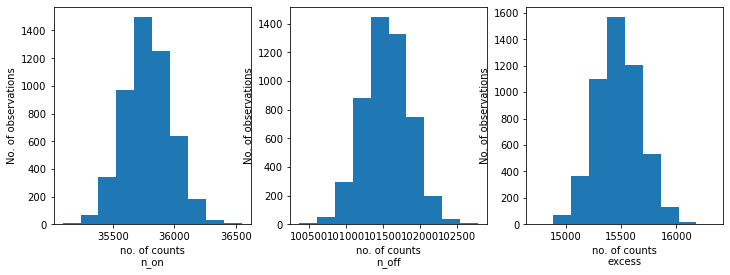

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 9min 37s, sys: 1.51 s, total: 9min 39s
Wall time: 9min 39s


In [15]:
results

[{'index': 2.2004131615267624,
  'amplitude': 1.3601486067384558e-12,
  'lambda_': 0.11118392218485627},
 {'index': 2.2186923632409274,
  'amplitude': 1.2740701906278792e-12,
  'lambda_': 0.10355633713292395},
 {'index': 2.2290865097653043,
  'amplitude': 1.2670462380582257e-12,
  'lambda_': 0.10267001537485579},
 {'index': 2.2298212935591573,
  'amplitude': 1.2642889222463049e-12,
  'lambda_': 0.09787260864958808},
 {'index': 2.241520319762935,
  'amplitude': 1.2651277900312725e-12,
  'lambda_': 0.09371184556562533},
 {'index': 2.2227177951774024,
  'amplitude': 1.2632522229738968e-12,
  'lambda_': 0.10172702474076745},
 {'index': 2.2390108273914753,
  'amplitude': 1.2625407510442764e-12,
  'lambda_': 0.0887897117289828},
 {'index': 2.2069527000591647,
  'amplitude': 1.313681166093688e-12,
  'lambda_': 0.11202134541516798},
 {'index': 2.2096971321107435,
  'amplitude': 1.3047687699340683e-12,
  'lambda_': 0.10273424521500699},
 {'index': 2.22604016793442,
  'amplitude': 1.262676439480

index: 2.219688480591462 += 0.012640266378584172


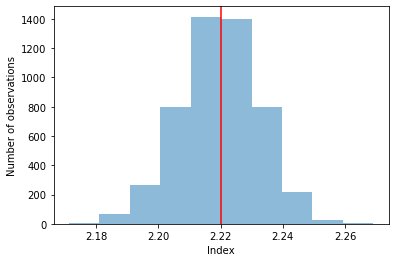

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2902595477317295e-12 += 2.861752589635892e-14


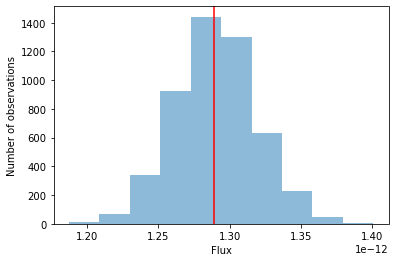

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.10042632177827615 += 0.00877212019165209


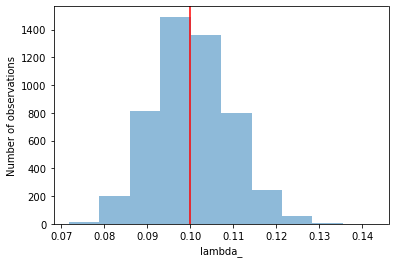

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")